In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Load the dataset
url = "https://raw.githubusercontent.com/DSE-24-25/project-OmarovTimur/main/data.csv"
data = pd.read_csv(url, comment='#')

# Display the first few rows of the dataset
data.head()

,Date,Anomaly
0,185001,-0.46
1,185002,-0.21
2,185003,-0.22
3,185004,-0.36
4,185005,-0.30


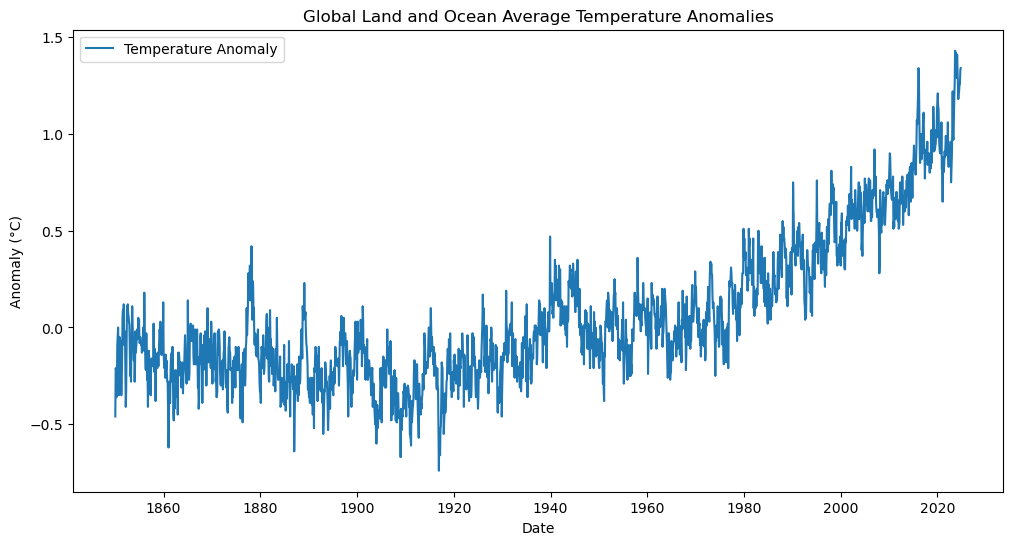

In [2]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m')
data.set_index('Date', inplace=True)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Anomaly'], label='Temperature Anomaly')
plt.title('Global Land and Ocean Average Temperature Anomalies')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

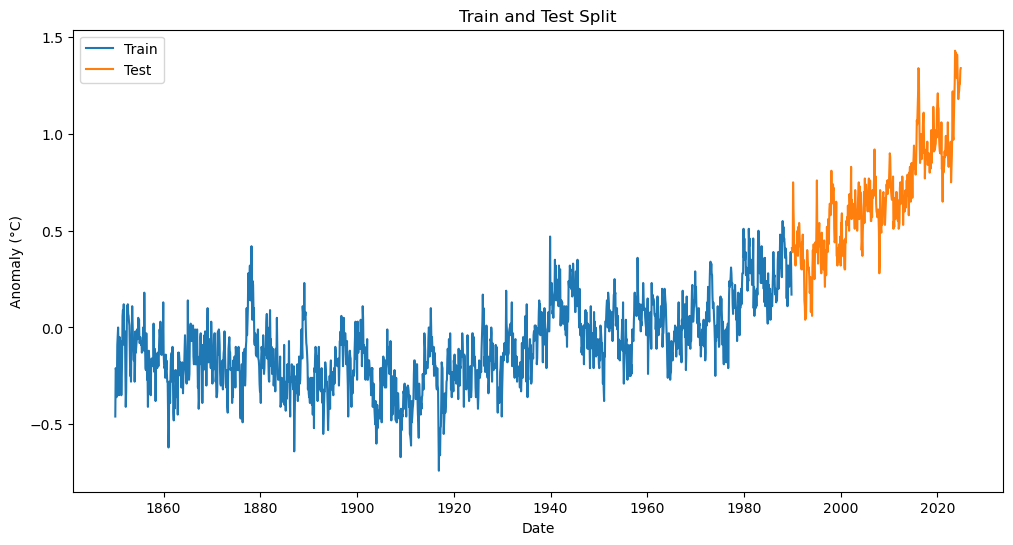

In [3]:
# Split the time series into train and test parts (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Plot the train and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Anomaly'], label='Train')
plt.plot(test.index, test['Anomaly'], label='Test')
plt.title('Train and Test Split')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

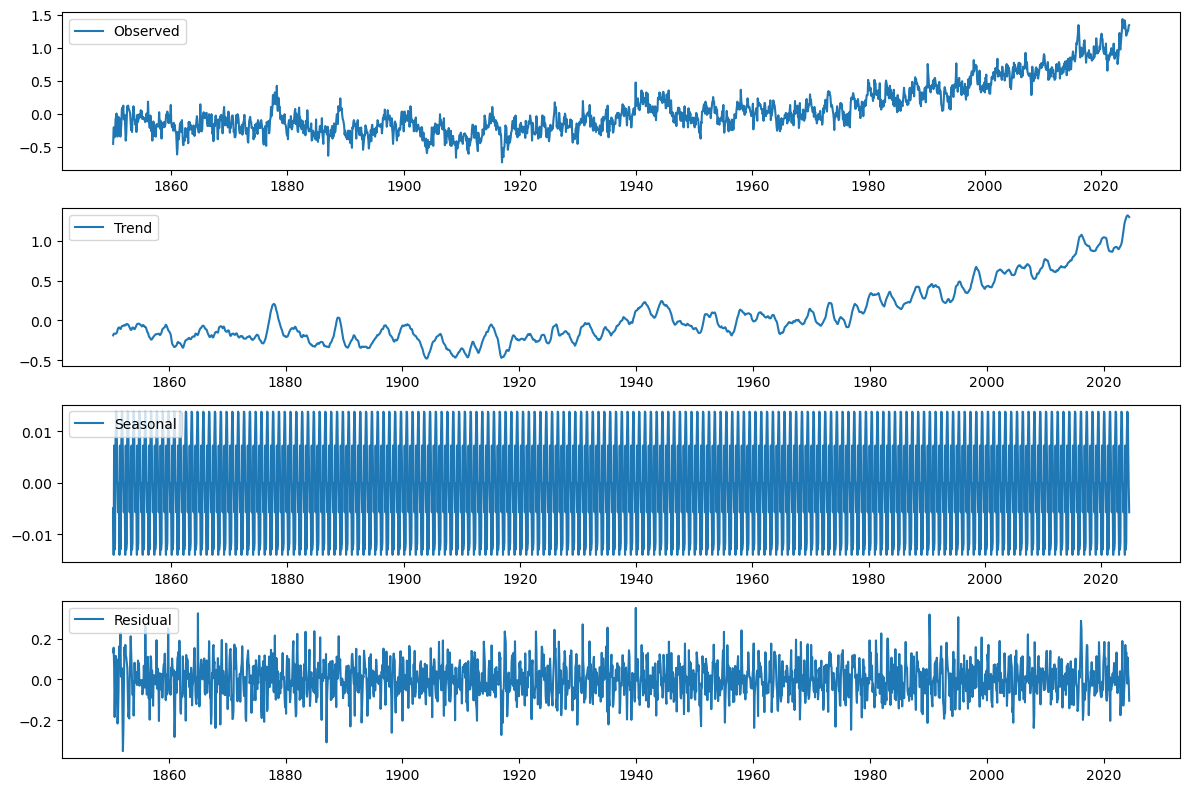

In [4]:
# Decompose the time series into trend, seasonal, and residual components
result = seasonal_decompose(data['Anomaly'], model='additive', period=12)

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_1084\1035200065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, 'Month'] = train.index.month
C:\Users\User\AppData\Local\Temp\ipykernel_1084\1035200065.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Month'] = test.index.month
C:\Users\User\AppData\Local\Temp\ipykernel_1084\1035200065.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

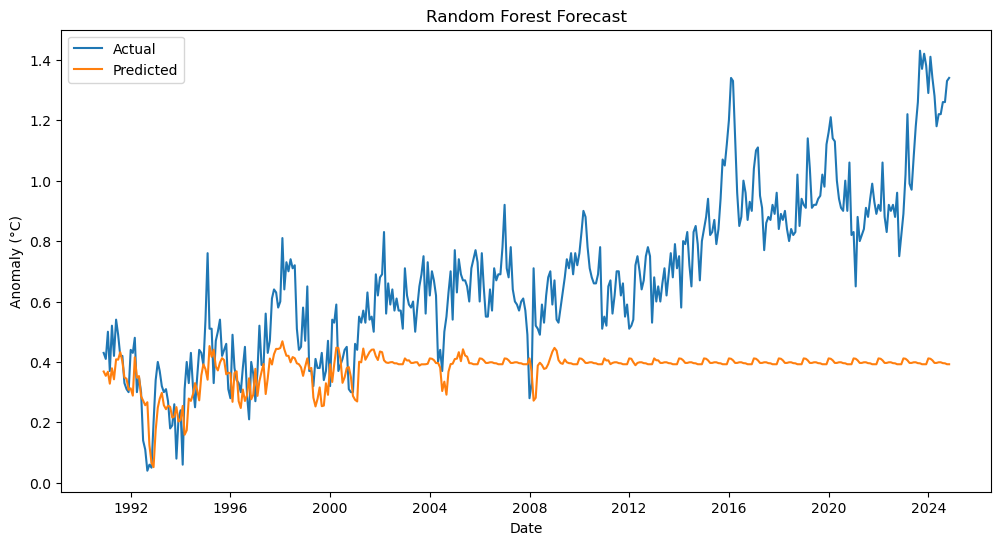

Random Forest Mean Squared Error: 0.14737081254901951


In [5]:
# Fixing the SettingWithCopyWarning by using .loc
# Feature engineering
train.loc[:, 'Month'] = train.index.month
test.loc[:, 'Month'] = test.index.month

# Create lag features
for lag in range(1, 13):
    train.loc[:, f'Lag_{lag}'] = train['Anomaly'].shift(lag)
    test.loc[:, f'Lag_{lag}'] = test['Anomaly'].shift(lag)

# Drop rows with NaN values (due to lagging)
train.dropna(inplace=True)
test.dropna(inplace=True)

# Define the features and target variable
X_train = train.drop(columns=['Anomaly'])
y_train = train['Anomaly']
X_test = test.drop(columns=['Anomaly'])
y_test = test['Anomaly']

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, rf_predictions, label='Predicted')
plt.title('Random Forest Forecast')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

# Calculate the mean squared error of the predictions
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f'Random Forest Mean Squared Error: {rf_mse}')

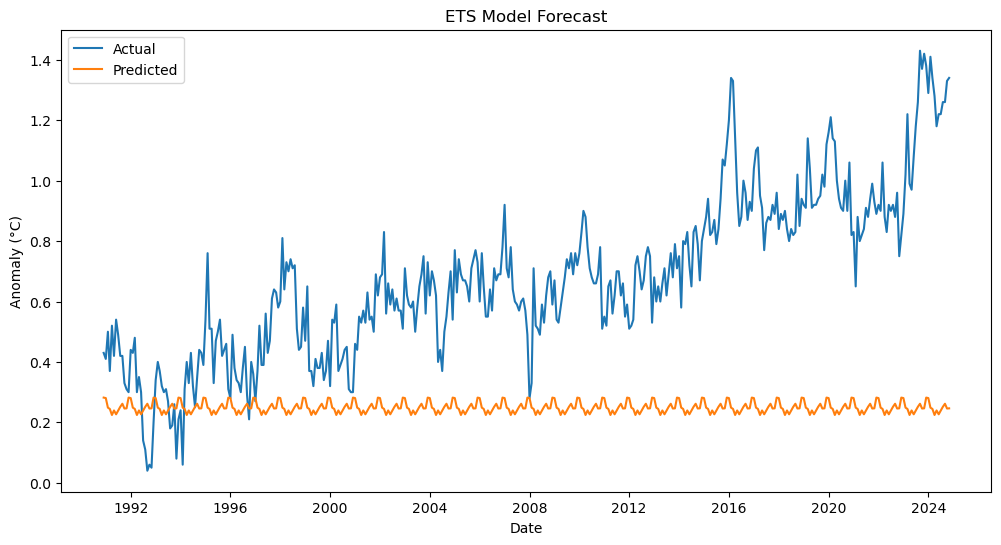

ETS Model Mean Squared Error: 0.25404486412335076


In [6]:
# Ensure the Date index has a specified frequency
train = train.asfreq('MS')
test = test.asfreq('MS')

# Train the Exponential Smoothing model on the training data
ets_model = ExponentialSmoothing(train['Anomaly'], seasonal='add', seasonal_periods=12).fit()

# Make predictions for the test period
ets_predictions = ets_model.forecast(len(test))

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, ets_predictions, label='Predicted')
plt.title('ETS Model Forecast')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

# Calculate the mean squared error of the predictions
ets_mse = mean_squared_error(y_test, ets_predictions)
print(f'ETS Model Mean Squared Error: {ets_mse}')

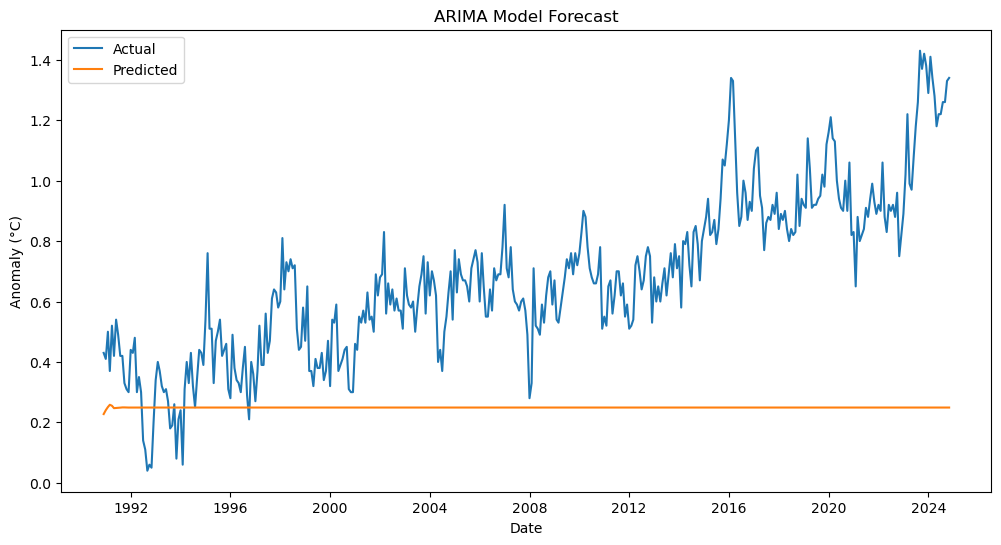

ARIMA Model Mean Squared Error: 0.2537166753242382


In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Train the ARIMA model
arima_model = ARIMA(train['Anomaly'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# Make predictions
arima_predictions = arima_model_fit.forecast(steps=len(test))

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, arima_predictions, label='Predicted')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()

# Calculate the mean squared error of the predictions
arima_mse = mean_squared_error(y_test, arima_predictions)
print(f'ARIMA Model Mean Squared Error: {arima_mse}')

Random Forest Mean Squared Error: 0.14737081254901951
ETS Model Mean Squared Error: 0.25404486412335076
ARIMA Model Mean Squared Error: 0.2537166753242382


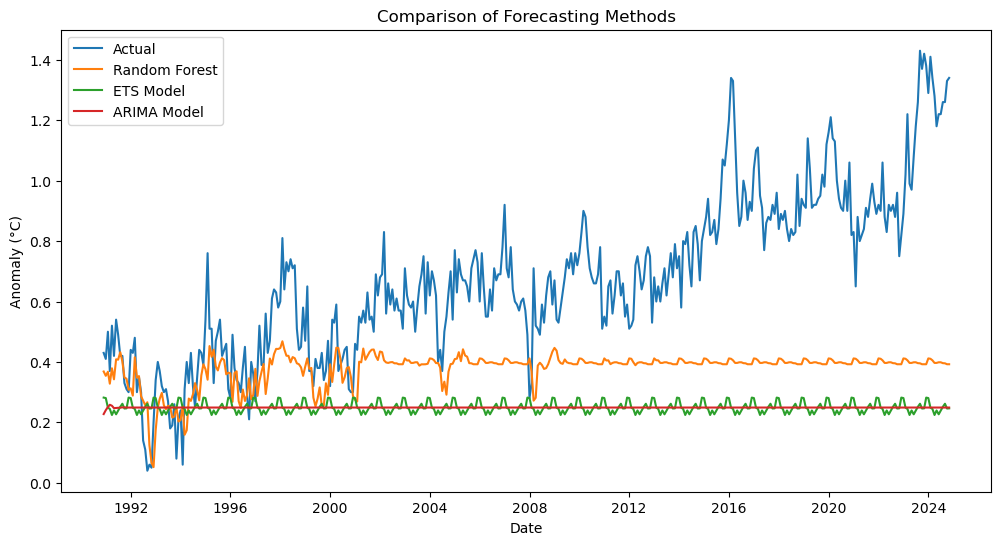

In [8]:
# Print the mean squared errors of the three models
print(f'Random Forest Mean Squared Error: {rf_mse}')
print(f'ETS Model Mean Squared Error: {ets_mse}')
print(f'ARIMA Model Mean Squared Error: {arima_mse}')

# Plot the actual values and the predictions of the three models
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, rf_predictions, label='Random Forest')
plt.plot(test.index, ets_predictions, label='ETS Model')
plt.plot(test.index, arima_predictions, label='ARIMA Model')
plt.title('Comparison of Forecasting Methods')
plt.xlabel('Date')
plt.ylabel('Anomaly (°C)')
plt.legend()
plt.show()